# Variogram Points Cloud

Variogram Point Cloud analysis is an additional, essential data preparation step that may save you a lot of headaches with more sophisticated analysis. Variogram point cloud shows distribution of semivariances along lags, and with this you can easily find outliers or heavily skewed distributions that affect modeling.

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
- **Package**:
  - `ExperimentalVariogram`
- **Programming**:
  - Python basics

## Table of contents

1. Create Variogram Point Cloud.
2. Analyze Variogram Point Cloud.
3. Detect and remove outliers.
4. Calculate experimental semivariance from the cloud.
5. Is Variogram Point Cloud a scatterplot?

## More resources

See `tutorials/api-examples/a-1-5-variogram-point-cloud` : directional point cloud and variogram cloud API.

In [1]:
# import packages
import geopandas as gpd
import numpy as np
import pandas as pd
from pyinterpolate import VariogramCloud

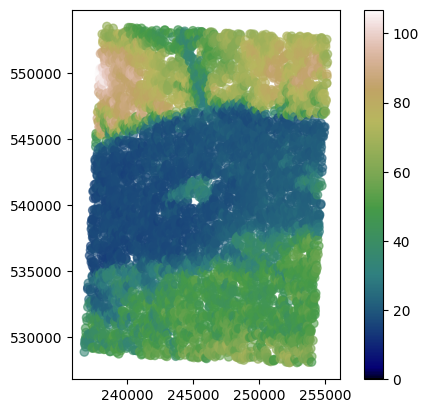

In [2]:
# Load DEM data

df = pd.read_csv(
    '../data/dem.csv'
)
# Populate geometry column and set CRS

dem_geometry = gpd.points_from_xy(x=df['longitude'], y=df['latitude'], crs='epsg:4326')
dem = gpd.GeoDataFrame(df, geometry=dem_geometry)

# Transform crs to metric values
dem.to_crs(epsg=2180, inplace=True)
dem.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True);

## 1. Create Variogram Point Cloud

We will generate the Variogram Point Cloud. We calculate it for 16 lags and test different cloud variogram visualization methods.

In [3]:
n_lags = 16
max_range = 10_000
step_size = max_range / n_lags

In [4]:
vc = VariogramCloud(
    ds=dem[['geometry', 'dem']],
    step_size=step_size,
    max_range=max_range
)

## 2. Analyze Variogram Point Cloud

### Check points statistics for each lag

We can use method `.describe()` to see general statistics for each lag. It might be useful when you automate your pipelines, to monitor your data drift.

- `count` : how many point pairs are grouped within lag
- `mean` : average semivariance (we will come back to this indicator later)
- `std` : standard deviation of semivariances between point pairs
- `min` : minimum semivariance between point pairs
- `max` : maximum semivariance between point pairs
- `25%` : 1st quartile of semivariances
- `median` : median semivariance, comparing it to mean might tell us how data is distributed, when those values are different then distribution is skewed in one direction
- `75%` : 3rd quartile of semivariances
- `skewness` : positive skewness might indicate that the distribution has a long right tail, negative skewness - the distribution has a long left tail, and zero might be a signal that distribution is balanced ([more about skewness](https://en.wikipedia.org/wiki/Skewness))
- `kurtosis` : `scipy` representation of kurtosis, the measure that might be useful for comparing distributions with the same mean and variance but different tails, and it might indicate outliers in a distribution ([more about kurtosis](https://www.youtube.com/watch?v=Pf7awGwzy4k))

In [5]:
vc.describe(as_dataframe=True)

625.0          1250.0         1875.0         2500.0  \
count     135536.000000  386278.000000  613496.000000  824114.000000   
mean          18.478983      43.719468      73.489310     107.858598   
std          126.662744     275.407396     419.778941     556.335979   
min            0.000000       0.000000       0.000000       0.000000   
max         3908.897133    4883.322511    5716.084231    5850.409025   
25%            0.479607       0.927684       1.326242       1.796418   
median         3.245548       7.752124      13.202538      20.709089   
75%           21.981884      58.321571     102.267010     156.939120   
skewness       9.024150       7.024262       5.707327       4.571970   
kurtosis     119.290276      64.629350      40.612849      24.571369   
lag          625.000000    1250.000000    1875.000000    2500.000000   

                3125.0        3750.0        4375.0        5000.0  \
count     1.012348e+06  1.186224e+06  1.340790e+06  1.479106e+06   
mean      1.478527e+02  1.875977e+02  2.312974e+02  2.768622e+02   
std       6.930238e+02  8.128981e+02  9.238568e+02  1.022283e+03   
min       0.000000e+00  3.274181e-11  1.455192e-11  0.000000e+00   
max       6.097542e+03  6.089071e+03  6.443930e+03  7.487043e+03   
25%       2.291578e+00  2.942269e+00  3.957437e+00  5.282839e+00   
median    3.139443e+01  4.577791e+01  6.744675e+01  9.467516e+01   
75%       2.217191e+02  2.976144e+02  4.071552e+02  5.543432e+02   
skewness  3.780406e+00  3.274606e+00  2.877575e+00  2.561271e+00   
kurtosis  1.598170e+01  1.138748e+01  8.427998e+00  6.462801e+00   
lag       3.125000e+03  3.750000e+03  4.375000e+03  5.000000e+03   

                5625.0        6250.0        6875.0        7500.0  \
count     1.599394e+06  1.696596e+06  1.778474e+06  1.847620e+06   
mean      3.205265e+02  3.616242e+02  4.027444e+02  4.367675e+02   
std       1.107589e+03  1.174940e+03  1.230325e+03  1.264571e+03   
min       3.637979e-12  1.309672e-10  0.000000e+00  4.401954e-10   
max       8.170291e+03  8.217915e+03  8.283208e+03  8.325632e+03   
25%       7.001901e+00  9.187945e+00  1.247976e+01  1.671459e+01   
median    1.282328e+02  1.712477e+02  2.327524e+02  3.030020e+02   
75%       7.001038e+02  8.333103e+02  9.602858e+02  1.073569e+03   
skewness  2.344063e+00  2.180223e+00  2.018141e+00  1.898245e+00   
kurtosis  5.308429e+00  4.580614e+00  3.828618e+00  3.284539e+00   
lag       5.625000e+03  6.250000e+03  6.875000e+03  7.500000e+03   

                8125.0        8750.0        9375.0  
count     1.897284e+06  1.936610e+06  1.959002e+06  
mean      4.649048e+02  4.902991e+02  5.148492e+02  
std       1.281077e+03  1.295998e+03  1.316194e+03  
min       0.000000e+00  3.637979e-12  3.637979e-12  
max       8.447563e+03  8.344179e+03  8.345417e+03  
25%       2.250293e+01  3.032104e+01  4.282639e+01  
median    3.885612e+02  4.708155e+02  5.404376e+02  
75%       1.181997e+03  1.269811e+03  1.356085e+03  
skewness  1.814415e+00  1.746984e+00  1.699327e+00  
kurtosis  2.974452e+00  2.742198e+00  2.588314e+00  
lag       8.125000e+03  8.750000e+03  9.375000e+03

This representation of data is tricky, and it shouldn't be the only step of data exploration. We need to look into distribution graphs.

The `VariogramCloud` class has three plot types:

- **Scatter plot** - shows the general dispersion of semivariances.
- **Box plot** - an excellent tool for outliers detection. It shows dispersion and quartiles of semivariances per lag. We can check distribution differences and their deviation from normality or skewness.
- **Violin plot** - it is a box plot on steroids. We can read all information from the box plot and see kernel density plots.

### Scatter plot

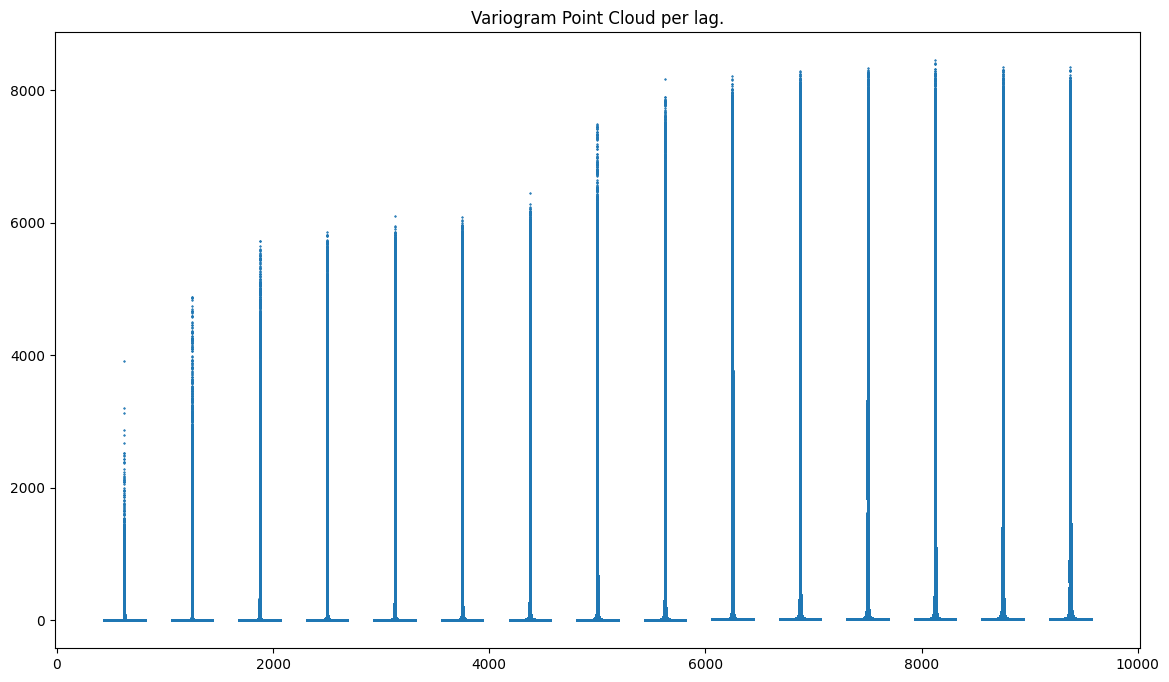

In [6]:
vc.plot('scatter');

The output per lag is dense, and distributions are not visible in this kind of plot. We will show when it is better to use scatterplot in the last part of the tutorial, now we will analyze other distribution plots.

### Box plot

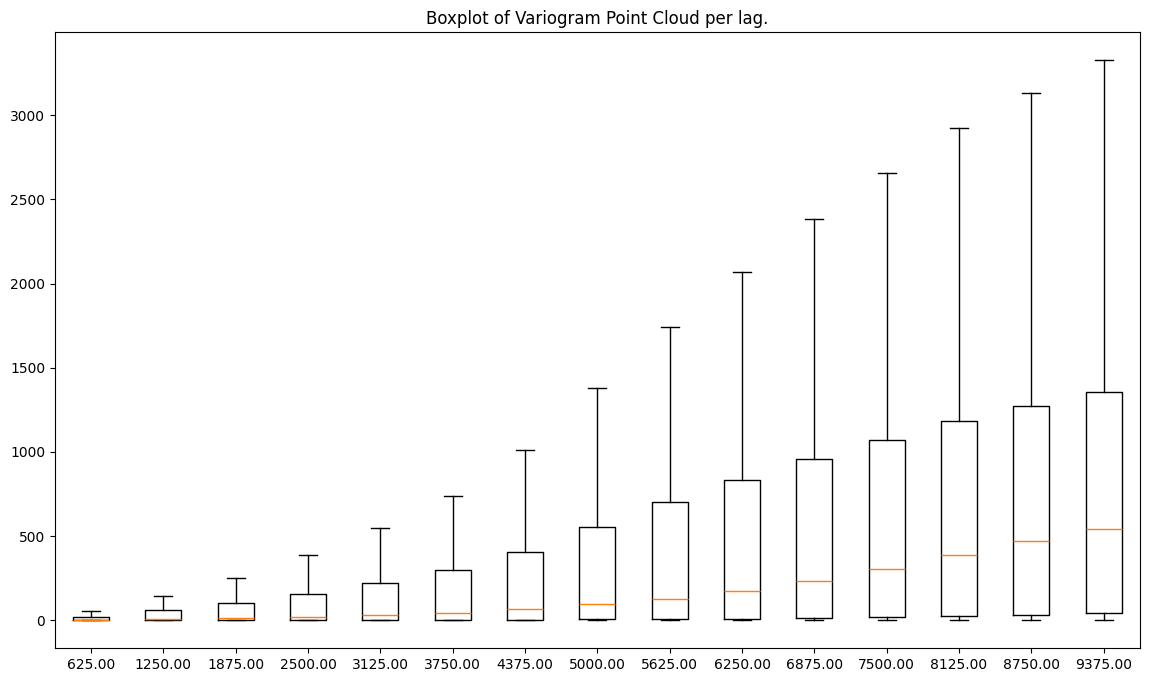

In [7]:
vc.plot('box');

The orange line in the middle of each box represents the median (50%) value per lag. Now we can guess how the trend line goes, but, more importantly, we see other properties of semivariances within lags:
1. Dispersion of values is greater with a distance, but at the same time, median and the 3rd quartile of semivariance values are rising (3rd quartile is plotted as a horizontal line on a top of a box.
2. The maximum value rises with a distance (it is a horizontal line on a top of a whisker).
Data is skewed towards lower values of semivariance. Why? Because the median is closer to the bottom of a box than the center or the top.
3. The 1st quartile (25% of the lowest values) is higher for distant lags.

### Violin plot

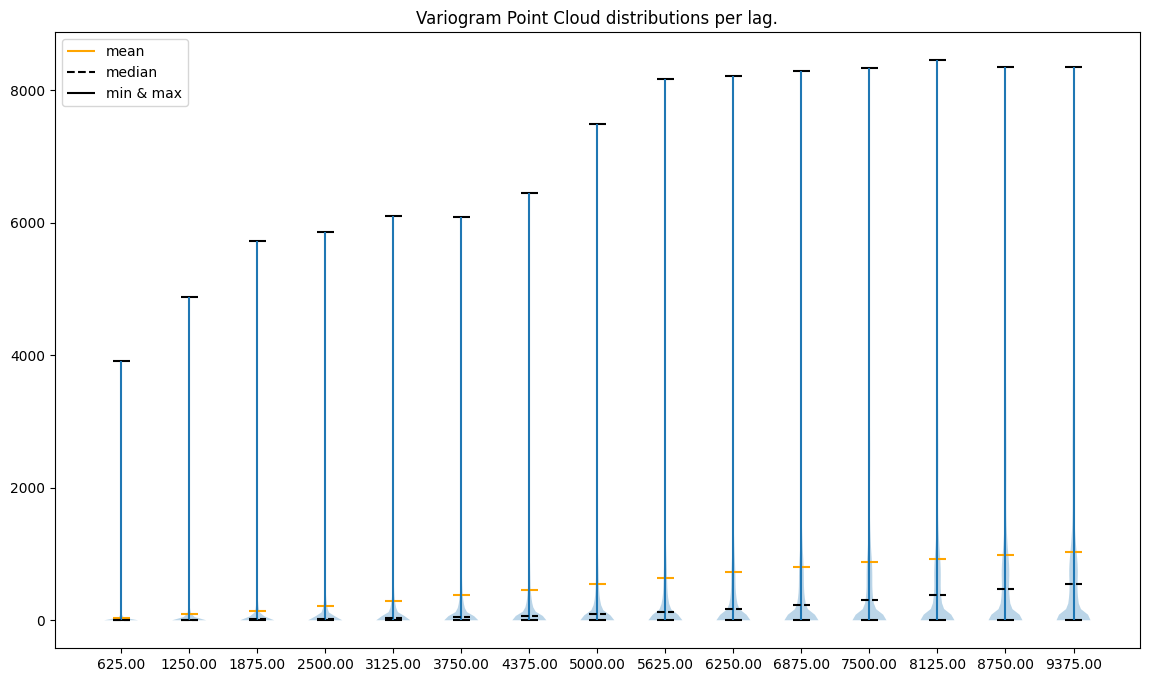

In [8]:
vc.plot('violin');

The violin plot supports our earlier assumptions, but we can find more insights here. For distant lags, distributions start to be multimodal. We see one mode around very low semivariance values and another close to the 1st quartile. Multimodality may affect our outcomes, and it may tell us that there is more than one level of spatial dependency.

## 3. Detect and remove outliers

There is still the elephant in the room - box plot and violin plot show that data is skewed towards large semivariance values (long whiskers). Those outliers may affect later modeling, we should consider cleaning data before Kriging.

We can remove points with too low | too high DEM values, or we can remove anomalous semivariances from the point cloud.

Our data is skewed towards large values. Thus, we will remove outliers from the upper part of the distribution. We will use the interquartile range algorithm. It detects outliers as all points below the first quartile of a data plus `m` (positive or zero `float`) standard deviations and all points above the 3rd quartile plus `n` (positive or zero `float`) standard deviations. The important thing is that the absolute values of `m` and `n` can differ. We should fit those values to the semivariance distributions.

The class `VariogramCloud` has internal method `.remove_outliers()`. With the parameter `inplace` set to `True`, we can overwrite the variogram point cloud, but if we set it to `False`, it will return the new `VariogramCloud` object with a cleaned variogram point cloud.

Other parameters that we are going to set of this method are:

- `method`: We have two methods, one based on the **z-score** and the second based on the **interquartile range**. Both have upper and lower bounds. The Z-score method is invoked with `method='zscore'`, and arguments for this function are `z_lower_limit` and `z_upper_limit` (number of standard deviations from the mean down and up, or negative and positive).
- `iqr_lower_limit`: how many standard deviations should be subtracted from the first quartile to set a limit of valid values,
- `iqr_upper_limit`: how many standard deviations should be added to the 3rd quartile to set a limit of valid values.

he values we will get will be within limits:

$$q1 - (m * std) < V < q3 + (n * std)$$

where:

- $q1$ - 1st quartile
- $q3$ - 3rd quartile
- $std$ - standard deviation
- $m$ - real number greater or equal than 0
- $n$ - real number greater or equal than 0
- $V$ - values in range

with the assumption, that $q1$, $q3$, $std$, and $V$ are lag-specific.

In [9]:
cvc = vc.remove_outliers(
    method='iqr',
    iqr_lower_limit=4,
    iqr_upper_limit=1.5,
    inplace=False
)

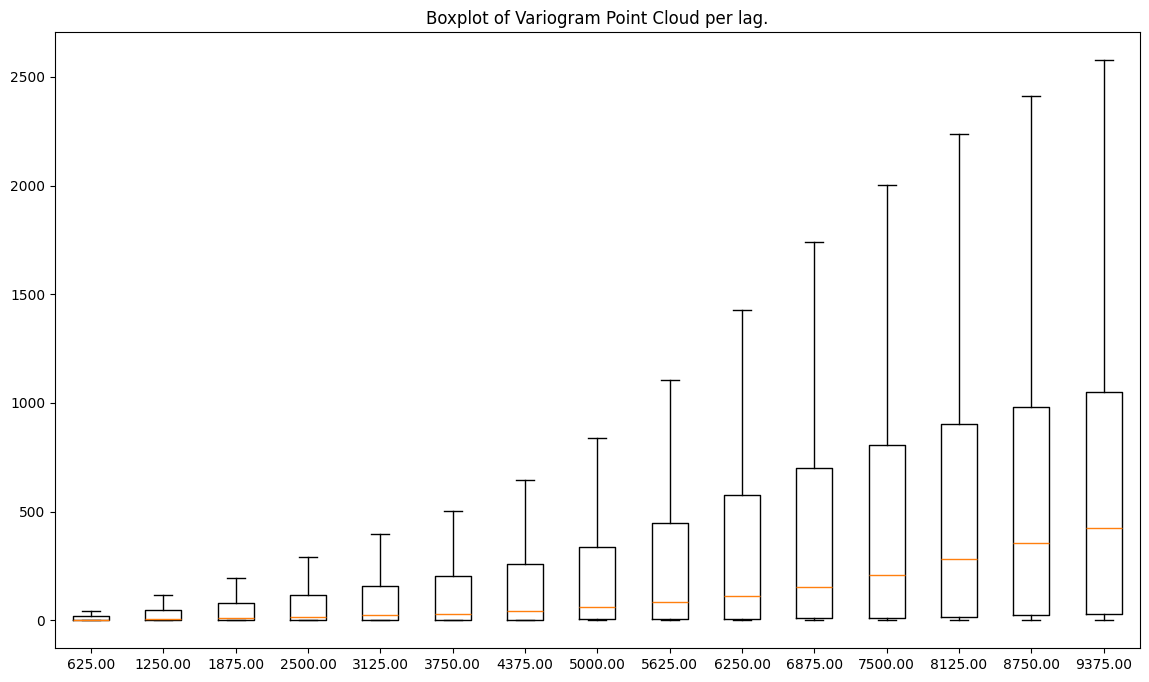

In [10]:
cvc.plot('box');

When we compare both figures - before and after data cleaning - we see that the y-axis of the second plot is few times smaller than the y-axis of the first plot! We've cleaned our data from the extreme values.

> **Note**: removing outliers from semivariance is one way of dealing with non-normal data distributions, but you should proceed with caution when you remove your observations or derivatives from those observations. You should check tutorial `tutorials/functional/3-3-outliers-and-kriging` to understand downsides of outliers removal.

## 4. Experimental variogram from the point cloud

The last but not least property of the experimental variogram point cloud is that we may calculate the semivariogram directly from it using `.calculate_experimental_variogram()` method.

In [11]:
exp_var = vc.experimental_semivariances()

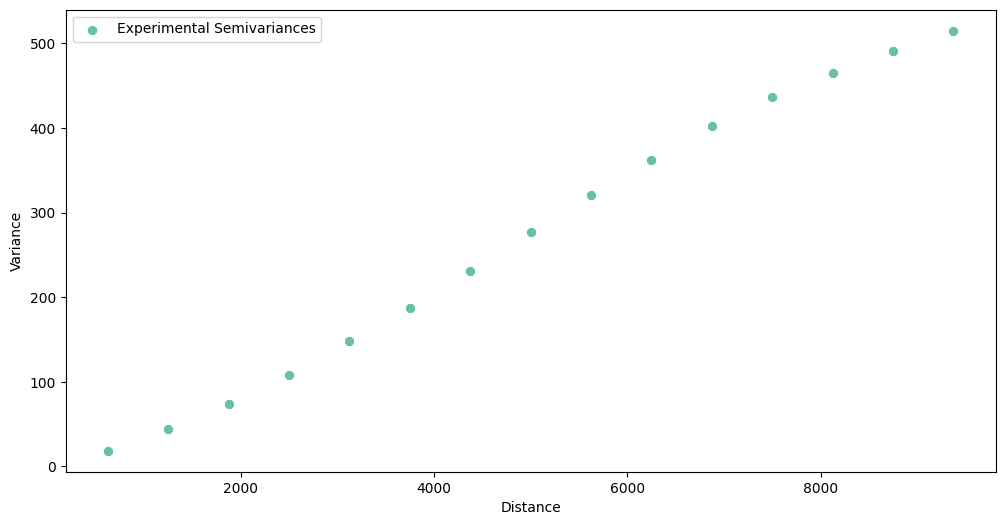

In [12]:
exp_var.plot(semivariance=True, covariance=False, variance=False)

The same points are under `mean` row in `.describe()` method:

In [13]:
vc.describe(as_dataframe=True).loc['mean']

625.0      18.478983
1250.0     43.719468
1875.0     73.489310
2500.0    107.858598
3125.0    147.852660
3750.0    187.597718
4375.0    231.297386
5000.0    276.862155
5625.0    320.526495
6250.0    361.624234
6875.0    402.744376
7500.0    436.767505
8125.0    464.904780
8750.0    490.299066
9375.0    514.849220
Name: mean, dtype: float64

In [14]:
exp_var.semivariances

array([ 18.47898266,  43.71946771,  73.48930987, 107.8585979 ,
       147.85265986, 187.59771789, 231.29738612, 276.86215475,
       320.52649515, 361.62423403, 402.74437591, 436.76750526,
       464.90478027, 490.29906598, 514.84922016])

## 5. Is variogram point cloud a scatter plot?

Yes, it is. But in `pyinterpolate`, we aggregated semivariances within bins (lags). If we remove bins (lags) completely then we get a scatter plot of semivariances. To simulate this behavior, we will create variogram cloud with 1000 lags.

In [15]:
step_size = max_range / 1000

In [16]:
vc1000 = VariogramCloud(
    ds=dem[['geometry', 'dem']],
    step_size=step_size,
    max_range=max_range
)

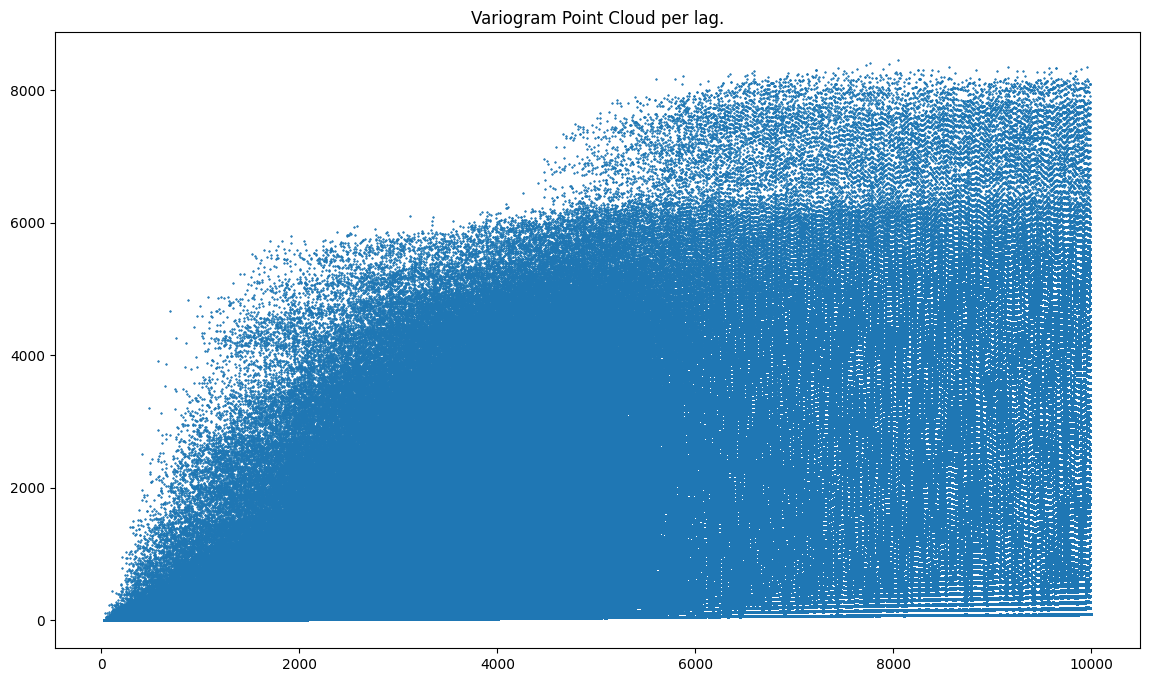

In [18]:
vc1000.plot('scatter');

## Changelog

| Date       | Changes                                      | Author                           |
|------------|----------------------------------------------|----------------------------------|
| 2025-04-26 | Tutorial has been adapted to the 1.0 release | @SimonMolinsky (Szymon Moliński) |